## Training with Indoor-Outdoor Temperature Difference as Input Feature

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
from sympy import symbols, sympify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import *  # 导入KAN 模块
from matplotlib.ticker import MaxNLocator

# Define early stopping training function with performance evaluation
def train_kan_with_early_stopping(model, dataset, patience=10, steps=10000):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()
        
        if step % 10 == 0:  # Logging every 10 steps
            print(f'Step [{step+1}/{steps}], Val Loss: {val_loss:.4f}') 

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        # Check if early stopping is triggered by loss threshold
        if val_loss < 0.001:
            print("Stopping training as val loss is below 0.001")
            break

        if patience_counter >= patience:
            print("Early stopping triggered due to no improvement")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Calculate metrics after training
    with torch.no_grad():
        test_predictions = model(dataset['test_input']).flatten()
        mae, mse, r2 = calculate_metrics(test_predictions, dataset['test_label'], y_std, y_mean)
        print(f'MAE: {mae}, MSE: {mse}, R2: {r2}') 

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

def generate_hourly_series(start_month, start_day, end_month, end_day):
    y0 = 2001  # 非闰年
    y1 = y0 if start_month <= end_month else y0 + 1
    
    full_year = pd.date_range(start=f'{y0}-01-01', end=f'{y1}-12-31 23:00:00', freq='h')

    start_date = f'{y0}-{start_month:02d}-{start_day:02d}'
    end_date = f'{y1}-{end_month:02d}-{end_day:02d} 23:59:59'
    filtered_series = full_year[(full_year >= start_date) & (full_year <= end_date)]
    
    hours_in_year = (filtered_series - pd.Timestamp(f'{y0}-01-01')).total_seconds() // 3600
    hours_in_year = hours_in_year % 8760  # Normalize for non-leap year

    return hours_in_year

In [7]:
import pandas as pd
import numpy as np
import torch
from sympy import symbols, sympify

# ========== Data Import ==========
dataset = pd.read_excel('K1-自保温-杭州.xlsx')
hours = generate_hourly_series(7, 15, 8, 15)
data = dataset.iloc[hours].copy()
data.reset_index(drop=True, inplace=True)

# Calculate indoor-outdoor temperature difference ΔT
data['Delta_T'] = data['Outdoor_temp'] - data['Indoor_temp']

N = 24  # Time lag steps
M = 1   # Prediction horizon

# Generate lagged features of ΔT
for lag in range(1, N):
    data[f'Delta_T_lag_{lag}'] = data['Delta_T'].shift(lag)

# Generate lagged features of Heat_flow (if only the current value is needed as output, this part can be ignored)
for lag in range(1, M):
    data[f'Heat_flow_lag_{lag}'] = data['Heat_flow'].shift(lag)

# Drop rows with missing values
data.dropna(inplace=True)

# Define input and output features
input_features = ['Delta_T'] + [f'Delta_T_lag_{i}' for i in range(1, N)]
output_features = ['Heat_flow'] + [f'Heat_flow_lag_{i}' for i in range(1, M)]

# Data extraction and normalization
x_data = data[input_features].values
y_data = data[output_features].values

x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0) + 1e-8
x_data_norm = (x_data - x_mean) / x_std

y_mean = np.mean(y_data)
y_std = np.std(y_data) + 1e-8
y_data_norm = (y_data - y_mean) / y_std

# Convert to Tensor
x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_data_norm, dtype=torch.float32)

# Split training and testing sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Initialize and train the KAN model
model = KAN(width=[x_data.shape[1], y_data.shape[1]], grid=20, k=5, seed=0)
train_kan_with_early_stopping(model, dataset, steps=200, patience=10)

# Automatically generate symbolic expressions
model.auto_symbolic(lib=['x'])  # Can add sin, exp to improve expressiveness
train_kan_with_early_stopping(model, dataset, steps=2000, patience=10)

# Output the symbolic expression
symbolic_formula_normalized = model.symbolic_formula()[0][0]
print("Discovered Symbolic Formula (Normalized):")
print(symbolic_formula_normalized)

# Performance evaluation
predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')


Step [1/200], Val Loss: 0.9965
Step [11/200], Val Loss: 0.7284
Step [21/200], Val Loss: 0.5309
Step [31/200], Val Loss: 0.3968
Step [41/200], Val Loss: 0.3105
Step [51/200], Val Loss: 0.2557
Step [61/200], Val Loss: 0.2206
Step [71/200], Val Loss: 0.1982
Step [81/200], Val Loss: 0.1842
Step [91/200], Val Loss: 0.1752
Step [101/200], Val Loss: 0.1689
Step [111/200], Val Loss: 0.1642
Step [121/200], Val Loss: 0.1603
Step [131/200], Val Loss: 0.1571
Step [141/200], Val Loss: 0.1545
Step [151/200], Val Loss: 0.1524
Step [161/200], Val Loss: 0.1508
Step [171/200], Val Loss: 0.1496
Step [181/200], Val Loss: 0.1486
Step [191/200], Val Loss: 0.1479
MAE: 1.1194474697113037, MSE: 2.070347785949707, R2: 0.8270374625413358
fixing (0,0,0) with x, r2=0.7288036346435547
fixing (0,1,0) with x, r2=0.6298463940620422
fixing (0,2,0) with x, r2=0.3038727045059204
fixing (0,3,0) with x, r2=0.21222196519374847
fixing (0,4,0) with x, r2=0.9170411229133606
fixing (0,5,0) with x, r2=0.9118960499763489
fixing (

MAE: 0.8080591559410095, MSE: 1.133821725845337, R2: 0.9193469285964966


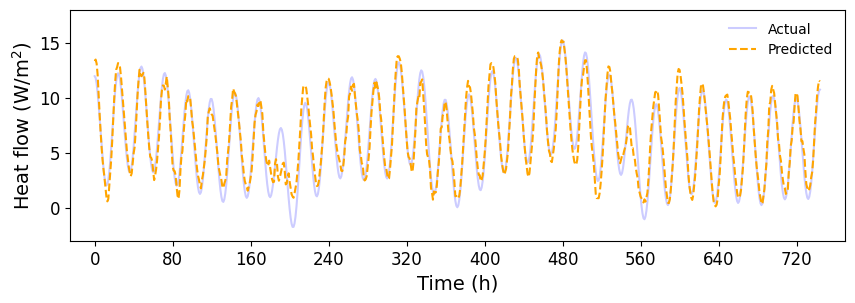

MAE: 0.8080591559410095, MSE: 1.133821725845337, R2: 0.9193469285964966


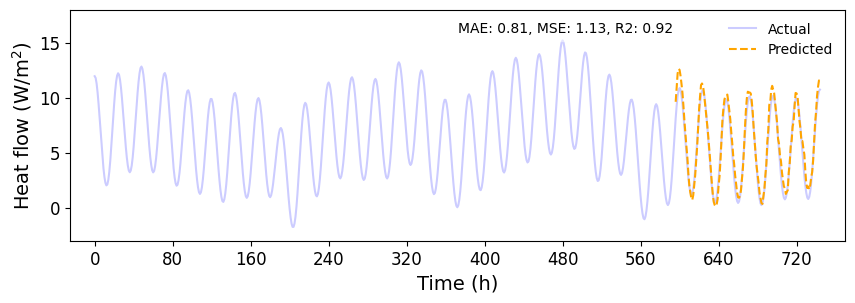

MAE: 1.7729068994522095, MSE: 4.789604187011719, R2: 0.8551859855651855


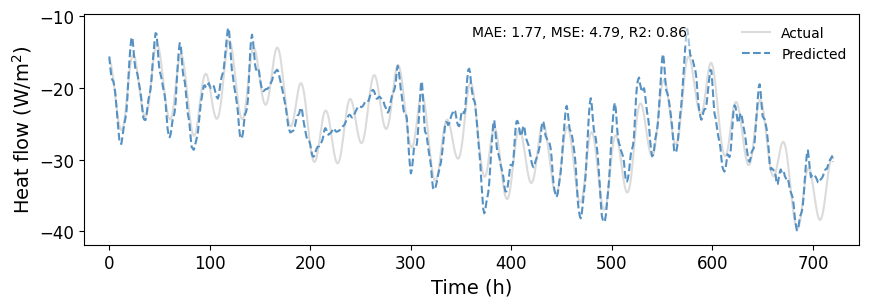

In [8]:
predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

total_points = len(predicted)
index_percent = int(total_points * 0.8)  # Calculate the index to start displaying data
x_axis_indices = np.arange(index_percent, total_points)  # Calculate the x-axis indices for the last 20% of data

plt.figure(figsize=(10, 3))

plt.plot(range(total_points), y_data, label='Actual', linestyle='-', color='blue', alpha=0.2)  
plt.plot(range(total_points), predicted * y_std + y_mean, label='Predicted', linestyle='--', color='orange') 
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points+25)  # X-axis range from 0 to total number of data points
plt.ylim(-3, 18)  # Set the Y-axis range
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # Set number of major ticks on x-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(5))  
plt.tick_params(axis='both', which='major', labelsize=12)  # Set major tick label size
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
# Save and display the plot
plt.savefig('ComparisonPlot_PredictedLast20Percent.png', dpi=300, bbox_inches='tight')
plt.show()

predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

plt.figure(figsize=(10, 3))

plt.plot(range(total_points), y_data, label='Actual', linestyle='-', color='blue', alpha=0.2)  
plt.plot(x_axis_indices, predicted[index_percent:] * y_std + y_mean, label='Predicted', linestyle='--', color='orange') 
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points+25)  # X-axis range from 0 to total number of data points
plt.ylim(-3, 18)  # Set the Y-axis range
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # Set number of major ticks on x-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(5))  
plt.tick_params(axis='both', which='major', labelsize=12)  # Set major tick label size
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
plt.text(0.5, 0.95, f'MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5, edgecolor='none'))

# Save and display the plot
plt.savefig('KAN-tranningResult.png', dpi=300, bbox_inches='tight')
plt.show()

# Data Import
# Data Import: Harbin
dataset = pd.read_excel('K1-自保温-哈尔滨.xlsx')
hours = generate_hourly_series(11, 15, 12, 15)
data = dataset.iloc[hours].copy()  # Key: ensure `data` is the dataset from Harbin
data.reset_index(drop=True, inplace=True)

# Calculate indoor-outdoor temperature difference ΔT
data['Delta_T'] = data['Outdoor_temp'] - data['Indoor_temp']

# Generate lagged features of ΔT
for lag in range(1, N):
    data[f'Delta_T_lag_{lag}'] = data['Delta_T'].shift(lag)

# Generate lagged features of Heat_flow (optional)
for lag in range(1, M):
    data[f'Heat_flow_lag_{lag}'] = data['Heat_flow'].shift(lag)

# Drop rows with missing values
data.dropna(inplace=True)

# Define input and output features
input_features = ['Delta_T'] + [f'Delta_T_lag_{i}' for i in range(1, N)]
output_features = ['Heat_flow'] + [f'Heat_flow_lag_{i}' for i in range(1, M)]

x_data = data[input_features].values
y_data = data[output_features].values

# Normalization
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0) + 1e-8
x_data_norm = (x_data - x_mean) / x_std
y_mean = np.mean(y_data)
y_std = np.std(y_data) + 1e-8
y_data_norm = (y_data - y_mean) / y_std

# Convert to tensor
x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_data_norm, dtype=torch.float32)

# Simulate some output predictions
predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

total_points = len(predicted)

# Create plot
plt.figure(figsize=(10, 3))

# Fit and denormalize
y_actual = y_data.flatten()
y_predicted = predicted * y_std + y_mean
y_min = min(np.min(y_actual), np.min(y_predicted)) - 2
y_max = max(np.max(y_actual), np.max(y_predicted)) + 2

# Plot data
plt.plot(range(total_points), y_actual, label='Actual', linestyle='-', color='#4c4c4c', alpha=0.2)
plt.plot(range(total_points), y_predicted, label='Predicted', linestyle='--', color='#5591c2')

# Set axes and display ranges
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points + 25)
plt.ylim(y_min, y_max)  # Automatically adapt to data range
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
plt.text(0.5, 0.95, f'MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5, edgecolor='none'))

# Save the figure
plt.savefig('KAN-extraploration.png', dpi=300, bbox_inches='tight')
plt.show()